In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import nltk

from nltk import sent_tokenize, word_tokenize, FreqDist
from nltk.data import load
from wordcloud import STOPWORDS

from sklearn import metrics, model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.metrics import log_loss, fbeta_score, make_scorer, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV

from os import path
from PIL import Image
from multiprocessing.dummy import Pool as ThreadPool 

from sklearn import datasets

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('cleaned_review_df.csv')

<h2>Redefine the Rating Category</h2>

In [4]:
def categorize_rating(r):
    if r < 4:
        return "Bad"
    elif r >= 4 and r < 5:
        return "Mediocre"
    else:
        return "Very good"

In [5]:
df['rating_category'] = df['rating'].apply(categorize_rating)

In [6]:
review_df = df[['rating_category', 'review']]

In [7]:
train, test = train_test_split(review_df, test_size = 0.3, random_state = 28)

In [8]:
def transform_tag(var):
    """Transforms a string to a string of pos_tag"""
    inpt = nltk.pos_tag(word_tokenize(var))
    unzipped = zip(*inpt)
    return ' '.join([*list(unzipped)[1]])

<h4>Generation of the tf_idf counting dataFrame</h4>

In [9]:
def counting_a(a, analysis):
    """
    Generates the tf-idf counting dataframe. First argument is the n of n-gram. Analysis type is 'word', 'char',
    token_pos', etc.
    """
    df_train = train.copy()
    df_test  = test.copy()
    
    #if we are counting words:
    if analysis == "word" or analysis == "char": 
        
        #check the CountVectorizer doc
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = analysis,
                                      lowercase = True, #we don't care about place in sentence
                                      ngram_range = (a, a),
                                      stop_words='english')

        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['review'])
        
        #we use bow_transformer to transform our test set. 
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['review'])
    
    #if we are counting POS:    
    elif analysis == "token_pos":
        
        #this is the punctuation we want to keep
        punctuation = r"(?u)\b\w\w+\b|!|\?|\"|\'|\.|\,|\;|\:|\$|\(|\)|\--|\&|\``|\'' + PRP$ + WP$"
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = 'word',
                                          lowercase = False, #we DO care about place in sentence
                                          ngram_range = (a, a),
                                          token_pattern =  punctuation, #we DO care about punctuation
                                          stop_words='english')
        
        #we use the transform_tag function to transform the sentence in a sentence of pos tag        
        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['review'].apply(transform_tag))
        #we use bow_transformer to transform our test set
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['review'].apply(transform_tag))

        
    #this is the DataFrame Concerning the regular counting of words
    ##from regular counting to tf idf transformation coefficient

    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    messages_tfidf_test = tfidf_transformer.transform(messages_bow_test)
    
    names = bow_transformer.get_feature_names()
    
    return (messages_tfidf, names, messages_tfidf_test)

In [10]:
def top_tfidf_feats(row, features, top_n=20):
    """Gets top n tf-idf values in row and return them with their corresponding feature names."""
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [11]:
def top_feats_in_doc(Xtr, features, row_id, top_n=20):
    """Returns the top n tf-df features in a specific document (i.e. matrix row)"""
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [12]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=20):
    """
    Returns the top n features that on average are most important amongst documents in rows.
    Indentified by indices in grp_ids.
    """
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [13]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=20):
    """
    Return a list of dfs, where each df holds top_n features and their mean tfidf value.
    Calculated across documents with the same class label.
    """
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [14]:
def plot_tfidf_classfeats_h(dfs, name = 'default'):
    """Plot the data frames returned by the function plot_tfidf_classfeats()."""
    fig = plt.figure(figsize=(12, 12), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    #this line is for showing
    plt.show()

<h3>Examplpe for 2-gram words, top-n per rating category</h3>

In [15]:
mat_word, name_word, mat_word_test = counting_a(2,'word')

print ('Shape of Sparse Matrix: ', mat_word.shape)
print ('Amount of Non-Zero occurences: ', mat_word.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word.nnz /
                             (mat_word.shape[0] * mat_word.shape[1])))
       
print(' ')
print ('Shape of Sparse Matrix Test: ', mat_word_test.shape)
print ('Amount of Non-Zero occurences: ', mat_word_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word_test.nnz /
                             (mat_word_test.shape[0] * mat_word_test.shape[1])))

Shape of Sparse Matrix:  (38439, 503396)
Amount of Non-Zero occurences:  1147380
sparsity: 0.01%
 
Shape of Sparse Matrix Test:  (16475, 503396)
Amount of Non-Zero occurences:  331089
sparsity: 0.00%


In [16]:
alpha_word = top_feats_by_class(mat_word, train.rating_category, name_word)

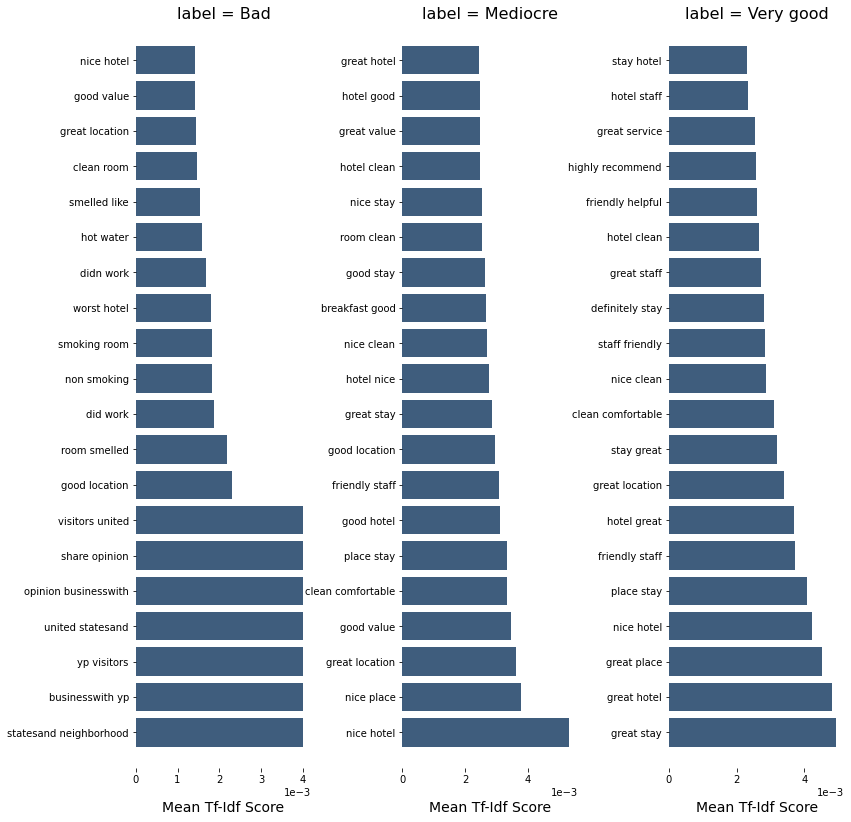

In [17]:
plot_tfidf_classfeats_h(alpha_word, '2_gram_word')

<h3>Examplpe for 3-gram character, top-n per rating category</h3>

In [18]:
mat_char, name_char, mat_char_test = counting_a(3, 'char')

print ('Shape of Sparse Matrix: ', mat_char.shape)
print ('Amount of Non-Zero occurences: ', mat_char.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_char.nnz /
                             (mat_char.shape[0] * mat_char.shape[1])))
print(' ')
print ('Shape of Sparse Matrix Test: ', mat_char_test.shape)
print ('Amount of Non-Zero occurences: ', mat_char_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_char_test.nnz /
                             (mat_char_test.shape[0] * mat_char_test.shape[1])))

Shape of Sparse Matrix:  (38439, 22904)
Amount of Non-Zero occurences:  9438280
sparsity: 1.07%
 
Shape of Sparse Matrix Test:  (16475, 22904)
Amount of Non-Zero occurences:  4073948
sparsity: 1.08%


In [19]:
alpha_char = top_feats_by_class( mat_char, train.rating_category, name_char)

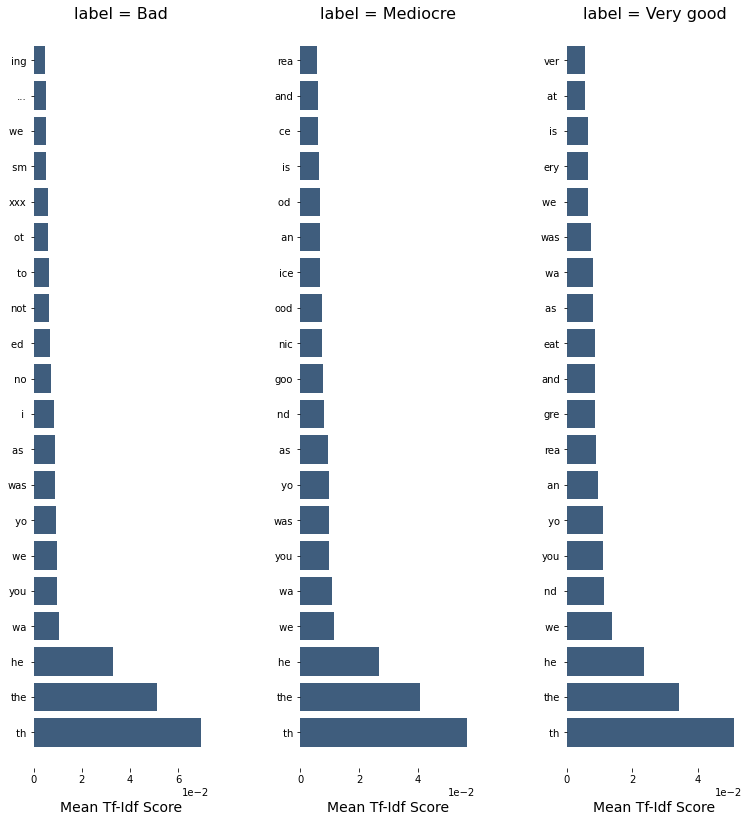

In [20]:
plot_tfidf_classfeats_h(alpha_char, '3_gram_char')

<h3>Examplpe for 4-gram POS, top-n per rating category</h3>

In [21]:
mat_pos, name_pos, mat_pos_test = counting_a(4, 'token_pos')

print ('Shape of Sparse Matrix: ', mat_pos.shape)
print ('Amount of Non-Zero occurences: ', mat_pos.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_pos.nnz /
                             (mat_pos.shape[0] * mat_pos.shape[1])))

print ('Shape of Sparse Test Matrix: ', mat_pos_test.shape)
print ('Amount of Non-Zero occurences: ', mat_pos_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_pos_test.nnz /
                             (mat_pos_test.shape[0] * mat_pos_test.shape[1])))

Shape of Sparse Matrix:  (38439, 129630)
Amount of Non-Zero occurences:  2654865
sparsity: 0.05%
Shape of Sparse Test Matrix:  (16475, 129630)
Amount of Non-Zero occurences:  1125044
sparsity: 0.05%


In [22]:
alpha_pos = top_feats_by_class(mat_pos, train.rating_category, name_pos)

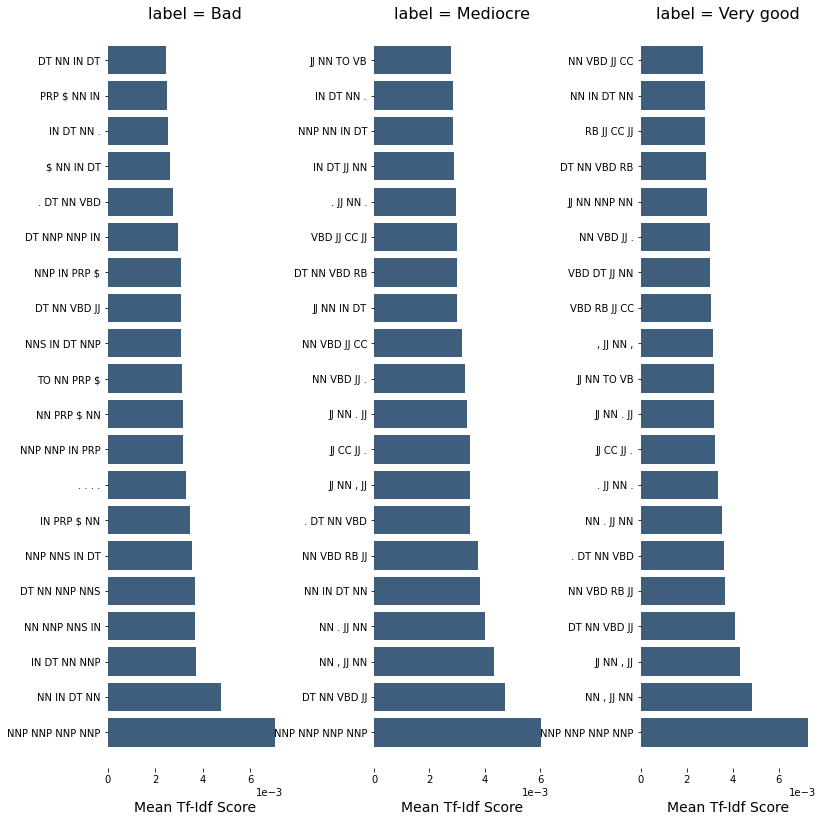

In [23]:
plot_tfidf_classfeats_h(alpha_pos, "4_gram_tag_pos")

<h3>Building of bag of word/character/PoS and feature vectors</h3>

In [24]:
def build_bag_a(a, analysis, top_n = 10):
    df_bag = train.copy()
    df_bag_test = test.copy()
    
    build = counting_a(a, analysis)
    
    alpha = top_feats_by_class(build[0], df_bag.rating_category, build[1], top_n = top_n)

    a = list(alpha[0].feature.values)
    b = list(alpha[1].feature.values)
    c = list(alpha[2].feature.values)
    bag = set(a + b + c)


    for w in bag:
        vec = build[0][:, build[1].index(w)].toarray()
        df_bag[w] = vec

        vec_test = build[2][:, build[1].index(w)].toarray()
        df_bag_test[w] = vec_test
        
    df_bag = df_bag.drop(labels = ['review','rating_category'], axis = 1)
    df_bag_test = df_bag_test.drop(labels = ['review','rating_category'], axis = 1)

        
    return df_bag, df_bag_test

In [25]:
build_bag_a(2, 'word')[0].head()

,good hotel,clean comfortable,united statesand,place stay,great place,statesand neighborhood,good value,share opinion,great location,yp visitors,...,good location,visitors united,great stay,businesswith yp,stay great,opinion businesswith,room smelled,nice hotel,nice place,great hotel
46010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
26440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
39429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
23575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
42304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107664,0.0,...,0.0,0.0,0.0,0.0,0.072344,0.0,0.0,0.0,0.0,0.0


In [26]:
build_bag_a(2, 'char')[0].head()

,th,re,w,in,he,d,a,t,t,s,e
46010,0.188662,0.160792,0.081622,0.055100,0.137105,0.052499,0.130559,0.157802,0.103926,0.239237,0.253994
26440,0.238920,0.059391,0.120593,0.142463,0.202567,0.058174,0.077158,0.252575,0.153546,0.117821,0.262685
39429,0.100476,0.133208,0.135239,0.068471,0.102226,0.228338,0.259587,0.130731,0.032286,0.066065,0.315631
23575,0.124372,0.041222,0.125551,0.084755,0.084358,0.121132,0.040165,0.121366,0.039965,0.163553,0.195347
42304,0.122541,0.155075,0.134949,0.079712,0.124675,0.162749,0.269823,0.163063,0.118130,0.065923,0.241464


In [27]:
build_bag_a(2,'token_pos')[0].head()

,NN VBD,IN DT,VBD RB,NN .,DT JJ,PRP VBD,PRP $,NNP NNP,NN IN,NN NN,DT NN,RB JJ,JJ NN,IN PRP
46010,0.000000,0.050313,0.000000,0.000000,0.000000,0.061263,0.000000,0.000000,0.051692,0.000000,0.091284,0.000000,0.000000,0.000000
26440,0.220918,0.181507,0.061132,0.088200,0.051647,0.000000,0.000000,0.000000,0.093241,0.055156,0.246985,0.054061,0.082951,0.060674
39429,0.101791,0.083631,0.112669,0.162556,0.095188,0.101833,0.000000,0.000000,0.085924,0.101656,0.151735,0.000000,0.076441,0.000000
23575,0.243812,0.100158,0.269870,0.097340,0.113999,0.000000,0.000000,0.144893,0.000000,0.000000,0.181721,0.238652,0.183094,0.000000
42304,0.000000,0.219726,0.000000,0.244050,0.214363,0.191105,0.042538,0.045409,0.096750,0.000000,0.085426,0.149586,0.200835,0.000000
